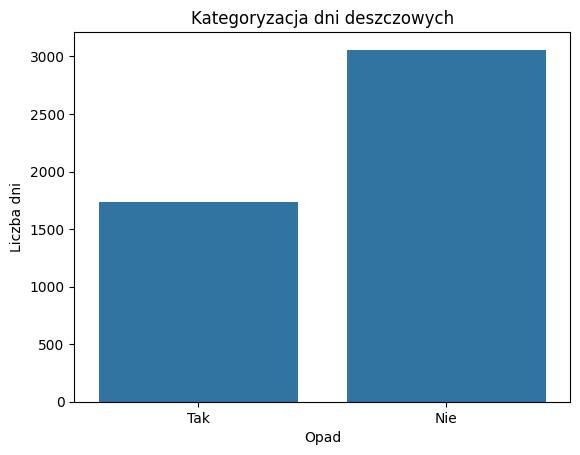

<ipython-input-2-95b2016bd111>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['RainTomorrow'] = y['RainTomorrow'].astype(int)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            acc_train  acc_test  prc_train  prc_test  rcl_train  rcl_test
KNN          0.812891  0.700418   0.776218  0.601375   0.678211  0.505780
DTC          0.793841  0.766180   0.786538  0.747967   0.590188  0.531792
LR           0.802453  0.766180   0.755899  0.714789   0.670274  0.586705
SVC linear   0.801931  0.778706   0.760166  0.735915   0.660895  0.604046
SVC rbf      0.784186  0.752610   0.752029  0.728033   0.601732  0.502890


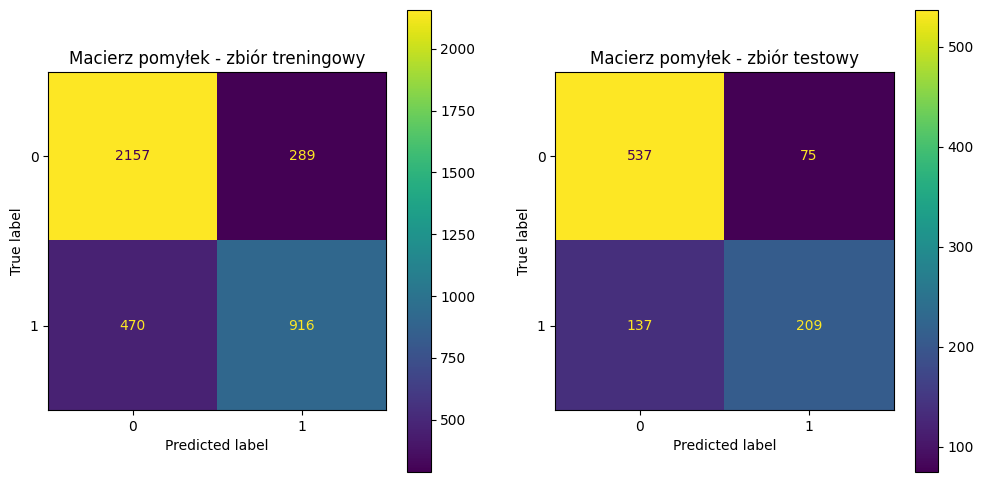

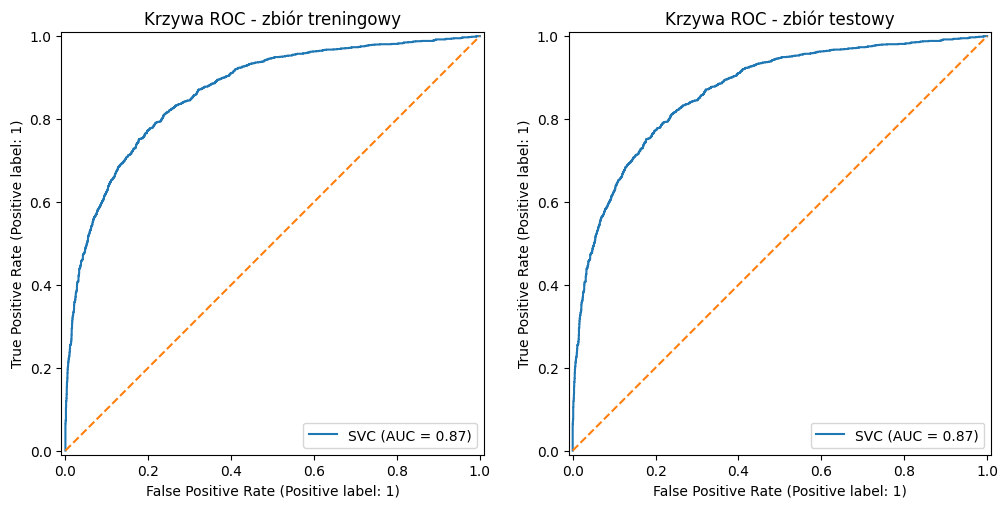

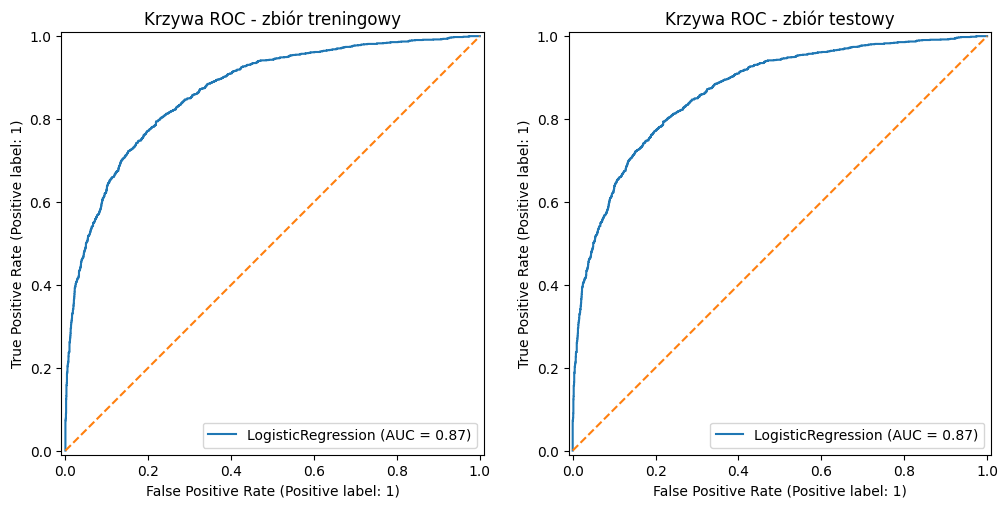

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

# Zadanie 1

# a)
df = pd.read_csv('weather_Portland.csv')

# b)
df.drop(
    columns=['Date', 'Location', 'Evaporation', 'Sunshine', 'RainToday', 'RISK_MM'],
    inplace=True,
)

# c)
df.dropna(subset=['RainTomorrow'], inplace=True)

# d)
df.dropna(thresh=len(df.columns) - 2, inplace=True)

# Zadanie 2

# a)
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
num_cols = df.select_dtypes(include=['number']).columns
df_numeric = df[num_cols]
df_numeric = pd.DataFrame(
    imputer_num.fit_transform(df_numeric), columns=df_numeric.columns
)
cat_cols = df.select_dtypes(exclude=['number']).columns
df_categorical = df[cat_cols]
df_categorical = pd.DataFrame(
    imputer_cat.fit_transform(df_categorical), columns=df_categorical.columns
)
df = pd.concat([df_numeric, df_categorical], axis=1)

# b}
df['Pressure9am'] = pd.cut(
    df['Pressure9am'],
    bins=[0, 980, 1000, 1020, 1040, 2000],
    labels=['bardzo_niskie', 'niskie', 'normalne', 'wysokie', 'bardzo_wysokie'],
)
df['Pressure3pm'] = pd.cut(
    df['Pressure3pm'],
    bins=[0, 980, 1000, 1020, 1040, 2000],
    labels=['bardzo_niskie', 'niskie', 'normalne', 'wysokie', 'bardzo_wysokie'],
)

# Zadanie 3

# a)
X = df.drop(columns=['RainTomorrow'])
y = df[['RainTomorrow']]

# b)
num_cols = list(df.select_dtypes(include=['number']).columns)
for column in num_cols:
    lower_bound = df[column].mean() - 3 * df[column].std()
    upper_bound = df[column].mean() + 3 * df[column].std()
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Zadanie 4

# a)
cp = sns.countplot(x=y['RainTomorrow'])
cp.set_xticks([0, 1])
cp.set_xticklabels(['Tak', 'Nie'])

# b)
cp.set_xlabel('Opad')
cp.set_ylabel('Liczba dni')

# c)
cp.set_title('Kategoryzacja dni deszczowych')

# d)
plt.show()

# Zadanie 5

# a)
oe = OrdinalEncoder(
    categories=[['bardzo_niskie', 'niskie', 'normalne', 'wysokie', 'bardzo wysokie']]
)
X['Pressure9am'] = oe.fit_transform(X[['Pressure9am']])
X['Pressure3pm'] = oe.fit_transform(X[['Pressure3pm']])

# b)
X = pd.get_dummies(X, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype=int)

# c)
le = LabelEncoder()
y.loc[:, 'RainTomorrow'] = le.fit_transform(y.loc[:, 'RainTomorrow'])
y['RainTomorrow'] = y['RainTomorrow'].astype(int)

# d)
mmsc = MinMaxScaler()
columns_to_normalize = [
    'MinTemp',
    'MaxTemp',
    'Rainfall',
    'WindGustSpeed',
    'WindSpeed9am',
    'WindSpeed3pm',
    'Humidity9am',
    'Humidity3pm',
    'Temp9am',
    'Temp3pm',
]
for column in columns_to_normalize:
    X[column] = mmsc.fit_transform(X[[column]])

# Zadanie 6

# a)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# b)
modelKnn = KNeighborsClassifier()
modelKnn.fit(X_train, y_train.values.ravel())


modelDtc = DecisionTreeClassifier(max_depth=4)
modelDtc.fit(X_train, y_train.values.ravel())

modelLr = LogisticRegression(penalty=None)
modelLr.fit(X_train, y_train.values.ravel())

modelSvcLinear = SVC(kernel='linear', C=10e3)
modelSvcLinear.fit(X_train, y_train.values.ravel())

modelSvcRbf = SVC(kernel='rbf')
modelSvcRbf.fit(X_train, y_train.values.ravel())

# c)
predictions = {}
predictions['KNN'] = [modelKnn.predict(X_train), modelKnn.predict(X_test)]
predictions['DTC'] = [modelDtc.predict(X_train), modelDtc.predict(X_test)]
predictions['LR'] = [modelLr.predict(X_train), modelLr.predict(X_test)]
predictions['SVC linear'] = [modelSvcLinear.predict(X_train), modelSvcLinear.predict(X_test)]
predictions['SVC rbf'] = [modelSvcRbf.predict(X_train), modelSvcRbf.predict(X_test)]

# Zadanie 7

# a)
results = pd.DataFrame(
    columns=['acc_train', 'acc_test', 'prc_train', 'prc_test', 'rcl_train', 'rcl_test']
)
for key, value in predictions.items():
    results.loc[key] = [
        accuracy_score(y_train, value[0]),
        accuracy_score(y_test, value[1]),
        precision_score(y_train, value[0]),
        precision_score(y_test, value[1]),
        recall_score(y_train, value[0]),
        recall_score(y_test, value[1]),
    ]

# b)
print(results)

# # c)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cm_train = confusion_matrix(y_train, predictions['SVC linear'][0])
ConfusionMatrixDisplay(cm_train).plot(ax=axes[0])
axes[0].set_title('Macierz pomyłek - zbiór treningowy')

cm_test = confusion_matrix(y_test, predictions['SVC linear'][1])
ConfusionMatrixDisplay(cm_test).plot(ax=axes[1])
axes[1].set_title('Macierz pomyłek - zbiór testowy')

# d)
# Krzywa ROC model SVC linear
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

RocCurveDisplay.from_estimator(modelSvcLinear , X_train, y_train, ax=axes[0])
axes[0].plot([0, 1], [0, 1], '--', c='C1')
axes[0].set_title('Krzywa ROC - zbiór treningowy')

# Krzywa ROC dla zbioru testowego
RocCurveDisplay.from_estimator(modelSvcLinear, X_train, y_train, ax=axes[1])
axes[1].plot([0, 1], [0, 1], '--', c='C1')
axes[1].set_title('Krzywa ROC - zbiór testowy')

# Krzywa ROC model regresji logistycznej
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Krzywa ROC dla zbioru treningowego
RocCurveDisplay.from_estimator(modelLr , X_train, y_train, ax=axes[0])
axes[0].plot([0, 1], [0, 1], '--', c='C1')
axes[0].set_title('Krzywa ROC - zbiór treningowy')

# Krzywa ROC dla zbioru testowego
RocCurveDisplay.from_estimator(modelLr , X_train, y_train, ax=axes[1])
axes[1].plot([0, 1], [0, 1], '--', c='C1')
axes[1].set_title('Krzywa ROC - zbiór testowy')

plt.show()
